## Using quilt

check to include the path to quilt in your PYTHONPATH

In [1]:
!echo $PYTHONPATH
%load_ext wurlitzer

/home/dianloo/Desktop/tesi/quilt


### The example network
In this example two dummy populations of AdEx neurons have excitatory connections with a delay narrowly peaked at 25 ms. 

Almost instantaneous (0.5 ms) self-inhibitory synapses are also present.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from rich import print

with open("spiking.yaml", "r") as network_file:
    net_params = yaml.safe_load(network_file)
    print(net_params)

{
    'populations': [
        {'name': 'Albert', 'size': 1000, 'neuron_type': 'aeif'},
        {'name': 'MonaLisa', 'size': 1000, 'neuron_type': 'aeif'}
    ],
    'projections': [
        {
            'name': 'AtoM',
            'efferent': 'Albert',
            'afferent': 'MonaLisa',
            'features': {'exc_fraction': 0.1, 'max_exc': 0.12, 'min_delay': 25, 'max_delay': 25.1}
        },
        {
            'name': 'albert-self',
            'efferent': 'Albert',
            'afferent': 'Albert',
            'features': {
                'inh_fraction': 0.05,
                'max_inh': 0.05,
                'min_delay': 0.1,
                'exc_fraction': 0.0,
                'max_delay': 0.5
            }
        },
        {
            'name': 'MtoA',
            'efferent': 'MonaLisa',
            'afferent': 'Albert',
            'features': {'exc_fraction': 0.05, 'max_exc': 0.12, 'min_delay': 25.0, 'max_delay': 25.1}
        },
        {
            'name': 'monalisa-self',
            'efferent': 'MonaLisa',
            'afferent': 'MonaLisa',
            'features': {'inh_fraction': 0.05, 'max_inh': 0.05, 'exc_fraction': 0.0, 'max_delay': 0.5}
        }
    ]
}

## Loading the network
Networks are stored in .yaml files.

In [3]:
from quilt.builder import SpikingNetwork

spikenet = SpikingNetwork.from_yaml("spiking.yaml")

Building population 0 took 0 ms    (0.262 us/neur)
Building population 1 took 0 ms    (0.199 us/neur)
Generating weights and delays took 0.030 seconds
Projection has density 10.0607%
Performing 100599 connections took 4 ms   (0.041233 us/link)
Generating weights and delays took 0.025 seconds
Projection has density 5.0035%
Performing 50023 connections took 2 ms   (0.0579134 us/link)
Generating weights and delays took 0.030 seconds
Projection has density 4.9956%
Performing 49951 connections took 3 ms   (0.0763548 us/link)
Generating weights and delays took 0.027 seconds
Projection has density 4.9918%
Performing 49913 connections took 2 ms   (0.0525114 us/link)


### Adding monitors
Not all variables are saved during evolution because variable monitors are both time and memory consuming.

In [4]:
spikenet.populations["Albert"].monitorize_spikes()
spikenet.populations["Albert"].monitorize_states()

spikenet.populations["MonaLisa"].monitorize_spikes()
spikenet.populations["MonaLisa"].monitorize_states()

### Adding an external stimulus

In [5]:
# Adds a constant current to population Albert of 500pA from t=0ms to t=10ms
spikenet.populations["Albert"].add_injector(500.0, 0, 10)

## Running

In [6]:
spikenet.interface.run(dt=0.1, time=500)

Running network consisting of 2000 neurons for 5000 timesteps
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Simulation took 4 s	(0.0008 s/step)
	Gathering time avg: 171.175 us/step
	Inject time avg: 0.0278 us/step


## Retrieving data: spikes
For now just spikes-for-timesteps are saved, thus without caring about which neuron fired.

In [7]:
albert_data = spikenet.populations['Albert'].get_data()
monalisa_data = spikenet.populations['MonaLisa'].get_data()

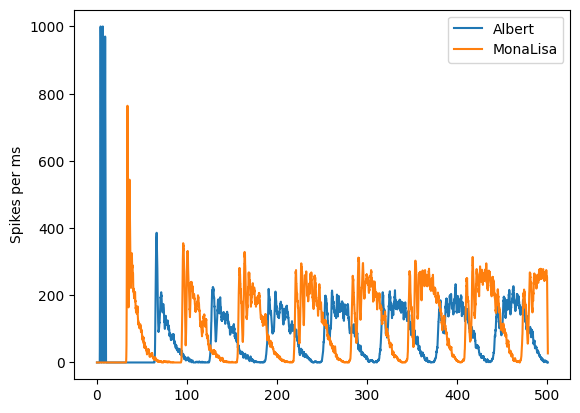

In [8]:
N = 10

plt.plot(np.arange(len(albert_data['spikes']) + N-1 )*0.1, 
         np.convolve(albert_data['spikes'], np.ones(N)), 
         label="Albert")

plt.plot(np.arange(len(monalisa_data['spikes']) + N-1 )*0.1, 
         np.convolve(monalisa_data['spikes'], np.ones(N)), 
         label="MonaLisa")

plt.ylabel("Spikes per ms");
plt.legend()

## Retrieving data: states

The state of a neuron consist of its membrane potential, synaptic conductances and (for adaptive neurons) the recovery variable.

In [9]:
states = np.array(albert_data['states'])

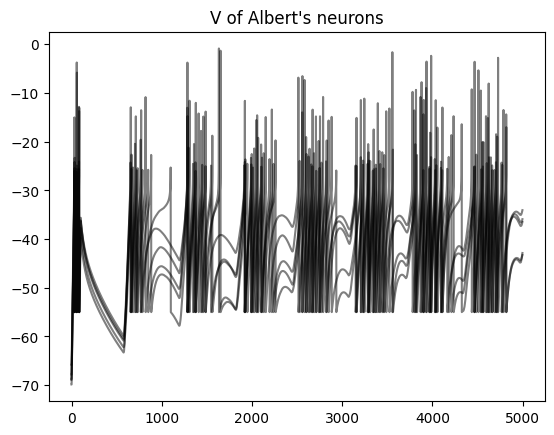

In [10]:
for i in range(5):
    plt.plot(states[:, i, 0], color="k", alpha=0.5)
    plt.title("V of Albert's neurons")

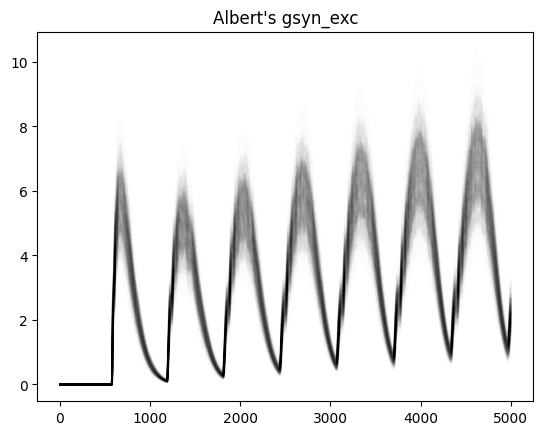

In [11]:
for i in range(200):
    plt.plot(states[:, i, 1], alpha=0.01, color="k")
    plt.title("Albert's gsyn_exc")

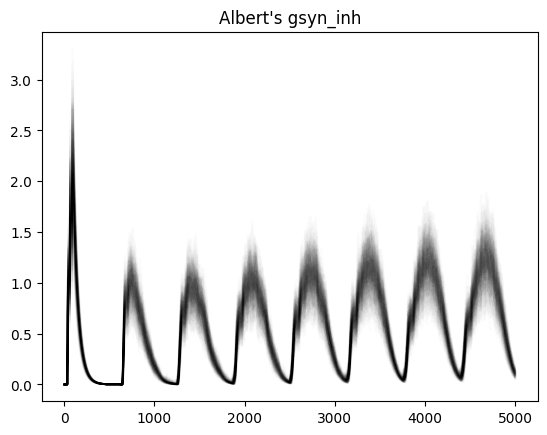

In [12]:
for i in range(200):
    plt.plot(states[:, i, 2], alpha=0.01, color="k")
    plt.title("Albert's gsyn_inh")

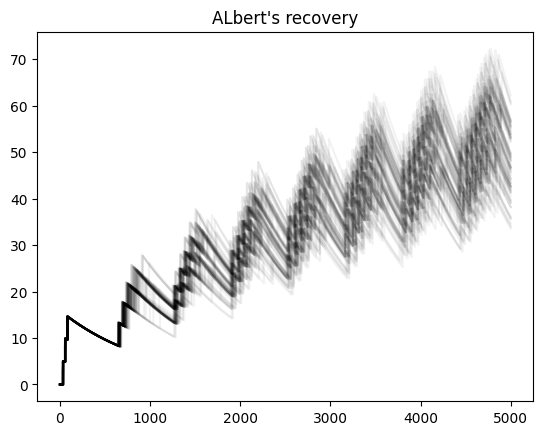

In [13]:
for i in range(100):
    plt.plot(states[:, i, 3], color="k", alpha=0.05)
    plt.title("ALbert's recovery")

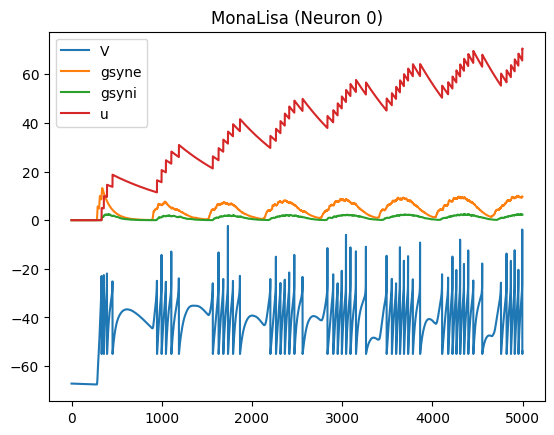

In [14]:
states = np.array(spikenet.populations['MonaLisa'].get_data()['states'])

for idx, feat in enumerate(["V", "gsyne", "gsyni", "u"]):
    plt.plot(states[:, 0, idx], label=feat)
plt.title("MonaLisa (Neuron 0)")
plt.legend()


plt.show()